<a href="https://colab.research.google.com/github/tushar-mahalya/Classifying-Buildings-Post-Hurricane/blob/root/AI2_Project_Hurricane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Buildings post Hurricane
The latest hurricane - Hurricane Iota, had 61 total fatalities, and 41 are still missing. After a hurricane, damage assessment is vital to the relief helpers and first responders so that resources and help can be planned and allocated appropriately. One way to measure the damage is to detect and quantify the number of damaged buildings, usually done by driving around the affected area and noting down manually. This process can be labor-intensive and time-consuming and not the most efficient method as well. Hence in this project, we ask you to classify buildings between damaged and not damaged buildings using the satellite imagery data provided to you. 

In [ ]:
!pip install tf_keras_vis
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 2.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 27.9 MB/s 


In [ ]:
import os
import timeit
import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import tensorflow as tf
from matplotlib import cm
from tensorflow import keras
import matplotlib.pyplot as plt
from prettytable import PrettyTable

import tensorflow_addons as tfa
from keras.preprocessing import image
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize
from tensorflow.keras.optimizers import Adam
from keras.applications import imagenet_utils
from tensorflow.keras.models import Model, Sequential
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input
from tensorflow.keras.preprocessing.image import  array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Activation, Conv2D, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D

# **⚙ Loading Data**

The dataset is collected from "[Geo-satellite sensor](https://www.satimagingcorp.com/satellite-sensors/geoeye-1/)" and "[Geo Bigdata](https://www.geobigdata.io/)". 
The data ( [DATASET](https://drive.google.com/file/d/1EH3p84xKMs_2m4ISSR7aHOQz61yxIv8L/view) ) that is provided to us has the following subfolders:  



1.   **train_another** : the training data; 5000 images of each class(damage/no damage)
2.   **validation_another** : the validation data; 1000 images of each class(damage/no damage)
3.   **test_another** : the unbalanced test data; 8000/1000 images of damaged/undamaged classes
4.   **test** : the balanced test data; 1000 images of each class(damage/no damage)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading Data :- 'Post-hurricane.zip' from Google Drive

data_path = '/content/drive/MyDrive/Project/project_data'
!unzip -qq drive/My\Drive/Project/project_data/Post-hurricane.zip
print('Data is Unzipped at /content')

Data is Unzipped at /content


In [ ]:
# Defining the path where our data is currently loaded

load_data_path = '/content'
train_dir = os.path.join(load_data_path,'train_another')
val_dir = os.path.join(load_data_path,'validation_another')
test1_dir = os.path.join(load_data_path, 'test')
test2_dir = os.path.join(load_data_path, 'test_another')
data_dir = [train_dir,val_dir,test1_dir,test2_dir]
print('Data is Mounted on the following Directories :-')
for dir in data_dir:
  print(dir)

Data is Mounted on the following Directories :-
/content/train_another
/content/validation_another
/content/test
/content/test_another


# **⛑ Data Augmentation**

After loading our data in the local runtime, we start processing our data by using `ImageDataGenerator()` which help us in data augmentation by rotating, resizing, shifting height/width and pre-processing data in accordance with the model in which we deploy our data into.

In [ ]:
# Initializing the ImageDataGenerator() Object for Augumenting Training, Validation and Testing Data

train_datagen = ImageDataGenerator(rotation_range = 20,
                                   width_shift_range = 0.3,
                                   height_shift_range = 0.3,
                                   shear_range = 0.2,
                                   preprocessing_function = preprocess_input)

val_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

test1_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

test2_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
# Generating Training Data from 'train_another'
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (224,224),
                                                    class_mode = 'binary',
                                                    shuffle = True)
# Generating Validation Data from 'validation_another'
val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size = (224,224),
                                                class_mode = 'binary',
                                                shuffle = True)
# Generating Test_1 Data from 'test'
test1_generator = test1_datagen.flow_from_directory(test1_dir,
                                                    target_size = (224,224),
                                                    class_mode = 'binary',
                                                    shuffle = True)
# Generating Test_2 Data from 'test_another'
test2_generator = test2_datagen.flow_from_directory(test2_dir,
                                                    target_size = (224,224),
                                                    class_mode = 'binary',
                                                    shuffle = True)

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


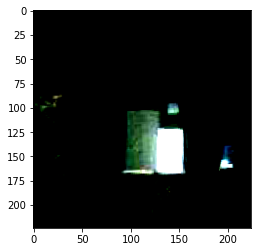

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


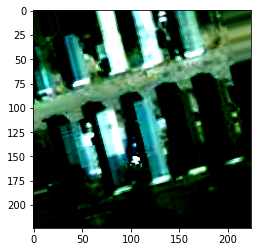

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


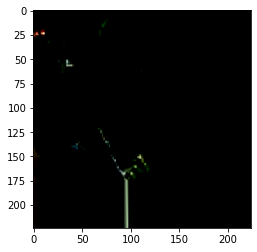

In [ ]:
for i in range(3):
    img, label = train_generator.next()
    plt.imshow(img[0])
    plt.show()

# **⚡ Building Convolutional Neural Network**

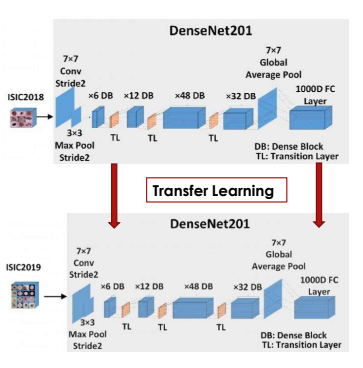

For our current Dataset, we have decided to go forward with the pre-trained **DenseNet201** Model in order to utilize Transfer Learning technique which helps our model to converge faster in more efficient and at very less computational cost.
We have connected the output of DenseNet201 architecture with a FullyConnected Dense() Layer of 1024 nodes with ReLu Activation and an output Dense() layer of single node with Sigmoid activation to get the probability of classes.
The DenseNet solves various problems by densly connecting all the layers. This means that each layer receives inputs from all the preceding layers and passes its own information to all subsequent layers,
which means that the final output layer has direct information from every single layer including the very first layer. This right here is supposed to improve the problem of redundant layer that is faced most often in complex NN architectures.

In [ ]:
# Creating the base pre-trained DenseNet201 Model
densenet_model = DenseNet201(input_shape = [224,224,3],
                             weights = 'imagenet',
                             include_top = False)

74850304/74836368 [==============================] - 0s 0us/step


In [ ]:
# Connecting output of our pre-trained model 
x = densenet_model.output

# Adding a Global Spatial Average Pooling layer
densenet_model.trainable=False
x = GlobalAveragePooling2D()(x)

# Adding a Fully-Connected layer
x = Dense(1024, activation = 'relu')(x)

# Final Output Layer with Sigmoid Activation
predictions = Dense(1, activation = 'sigmoid')(x)

# Finalizing the Model
model = Model(inputs = [densenet_model.input],
              outputs = [predictions])
model.summary()

# **🦾 Model Training & Compilation**

### Time for Train our model !
We have used Binary Crossentropy as a loss fuction during compilation since we are dealing with only two classes for classification (damage/no_damage). We also used Adam optimizer with LR @ 0.001 and Accuracy as a metric for evaluation.
Lastly, we have monitered validatin accuracy using EarlyStopping to avoid overfitting and extra utilization of resources (GPU) with patience of @3. 

In [ ]:
# Function for calculating Step Size
def step_size(data):
  step = (data.n)//(data.batch_size)
  return step

callback = EarlyStopping(monitor = 'val_accuracy',
                         restore_best_weights = True,
                         patience = 3)

model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
# Model Fitting
history = model.fit(train_generator,
          validation_data = val_generator,
          steps_per_epoch = step_size(train_generator),
          validation_steps = step_size(val_generator),
          epochs = 50,
          callbacks = [callback])

Epoch 1/50
312/312 [==============================] - 163s 440ms/step - loss: 0.2605 - accuracy: 0.8912 - val_loss: 0.1459 - val_accuracy: 0.9441
Epoch 2/50
312/312 [==============================] - 133s 426ms/step - loss: 0.1576 - accuracy: 0.9372 - val_loss: 0.1317 - val_accuracy: 0.9456
Epoch 3/50
312/312 [==============================] - 138s 442ms/step - loss: 0.1355 - accuracy: 0.9460 - val_loss: 0.1448 - val_accuracy: 0.9441
Epoch 4/50
312/312 [==============================] - 136s 436ms/step - loss: 0.1256 - accuracy: 0.9502 - val_loss: 0.1129 - val_accuracy: 0.9582
Epoch 5/50
312/312 [==============================] - 133s 427ms/step - loss: 0.1216 - accuracy: 0.9498 - val_loss: 0.0985 - val_accuracy: 0.9632
Epoch 6/50
312/312 [==============================] - 134s 430ms/step - loss: 0.1062 - accuracy: 0.9541 - val_loss: 0.0882 - val_accuracy: 0.9647
Epoch 7/50
312/312 [==============================] - 134s 430ms/step - loss: 0.1011 - accuracy: 0.9587 - val_loss: 0.0929 -

In [ ]:
# Saving Weights
model.save_weights('/content/drive/MyDrive/project_weights.h5')

In [ ]:
# Loading weights
model.load_weights('/content/drive/MyDrive/project_weights.h5')

# **💯 Model Evaluation**

We evaluated the Loss and Accuracy of both training and validation data of our model. We have found pretty impressive results on all the daatset provided for testing and there are no sign of overfitting on our model since accuracy/performance of our model is almost same for all datasets.  

In [ ]:
# Evaluating the Loss and Accuracy of our Model on Validation, Test_1 and Test_2 Data
val_loss_acc = model.evaluate(val_generator,steps=step_size(val_generator))
test1_loss_acc = model.evaluate(test1_generator, steps=step_size(test1_generator))
test2_loss_acc = model.evaluate(test2_generator,steps=step_size(test2_generator))

281/281 [==============================] - 43s 151ms/step - loss: 0.0768 - accuracy: 0.9698


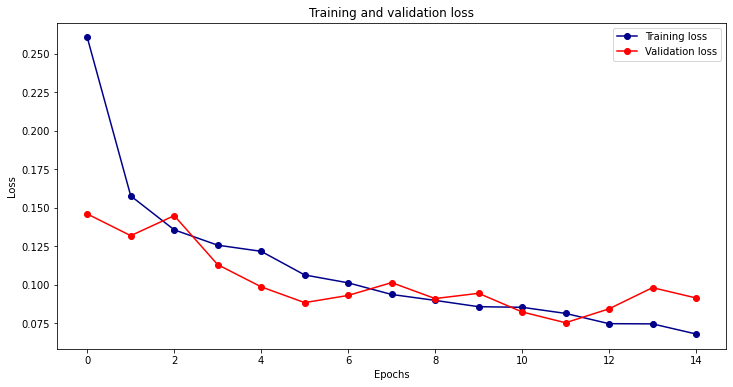

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(range(15),history.history['loss'],label='Training loss',color='darkblue',marker='o')
plt.plot(range(15),history.history['val_loss'],label='Validation loss',color='r',marker='o')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.show()

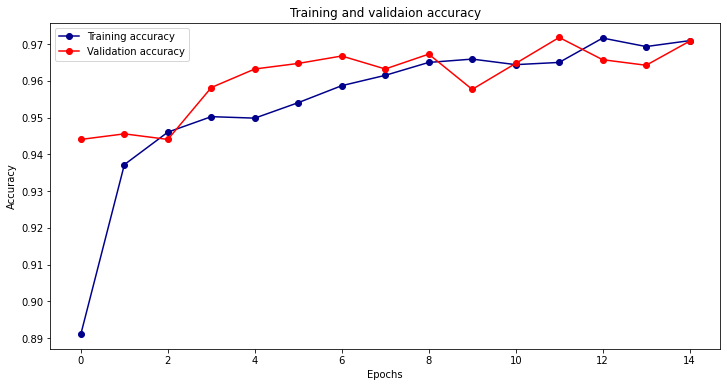

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(range(15),history.history['accuracy'],label='Training accuracy',color='darkblue',marker='o')
plt.plot(range(15),history.history['val_accuracy'],label='Validation accuracy',color='r',marker='o')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and validaion accuracy')
plt.show()

In [ ]:
Table = PrettyTable(["Data", "Loss", "Accuracy"])
Table.add_row(['test', round(test1_loss_acc[0],4), str(round(test1_loss_acc[1]*100, 2))+'%'])
Table.add_row(['test_another', round(test2_loss_acc[0],4), str(round(test2_loss_acc[1]*100, 2))+'%'])
Table.add_row(['validation_another', round(val_loss_acc[0],4), str(round(val_loss_acc[1]*100, 2))+'%'])
print(Table)

+--------------------+--------+----------+
|        Data        |  Loss  | Accuracy |
+--------------------+--------+----------+
|        test        | 0.0728 |  96.93%  |
|    test_another    | 0.0768 |  96.98%  |
| validation_another | 0.0748 |  97.18%  |
+--------------------+--------+----------+


# **⛰ Visualizing Model**

In order to evaluate our model's comprehenssion of different classes,  we have plotted :-

**Feature Map** : To understand the comprehenssion of different features by our model on different layers.

**Saliency Map** : To understand the degree of importance of a feature for classification.

**GradCam Heatmap** : To understand the areas where our model is mostly focussing on to distinguish between different classes.

For visual evaluation, we have selected random image of both the classes each for better understanding of results.

In [ ]:
img_path = '/content/drive/MyDrive/Project/project_data/sample_images/'
no_damage = 'sample_1.jpeg'
damage = 'sample_4.jpeg'

In [ ]:
def prepare_image(file, row, height):
  img = image.load_img(img_path + file, target_size=(row, height))
  # converting .jpeg image to array = (height, width, channels)
  img_arr = image.img_to_array(img)
  # adding batch_size in dimensions
  img_arr_exp = np.expand_dims(img_arr, axis=0)
  return preprocess_input(img_arr_exp)

### **Feature Maps**

In [ ]:
def get_feature_maps(model, layer_id, input_image):
    model_ = Model(inputs=[model.input], outputs=[model.layers[layer_id].output])
    return model_.predict(np.expand_dims(input_image, axis=0))[0,:,:,:].transpose((2,0,1))

In [ ]:
def plot_feature_maps(image):
  input_image = prepare_image(image,224,224)
  input_image = tf.squeeze(input_image)

  maps_1 = get_feature_maps(model, 1, input_image)
  maps_2 = get_feature_maps(model, 2, input_image)

  map_mid_1 = get_feature_maps(model, 5, input_image)
  map_mid_2 = get_feature_maps(model, 6, input_image)

  fig, ax = plt.subplots()
  ax.imshow(input_image + 0.5)
  ax.set_title('Sample Image')
  ax.grid(False)
  ax.axis('off')

  fig, ax = plt.subplots(4,3, figsize=(8,10))
  axes = ax.ravel()
  for map,i in enumerate(range(3)):
    axes[i].imshow(maps_1[map], cmap='gray')
    axes[i].set_title('Layer-1')
  for map,j in enumerate(range(3,6)):
    axes[j].imshow(maps_2[map], cmap='gray')
    axes[j].set_title('Layer-2')
  for map,k in enumerate(range(6,9)):
    axes[k].imshow(map_mid_1[map], cmap='gray')
    axes[k].set_title('Layer-5')
  for map,l in enumerate(range(9,12)):
    axes[l].imshow(map_mid_2[map], cmap='gray')
    axes[l].set_title('Layer-6')
  for axe in axes:
    axe.grid(False)
    axe.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


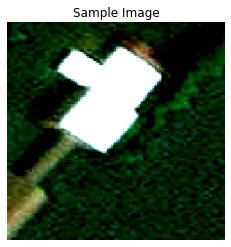

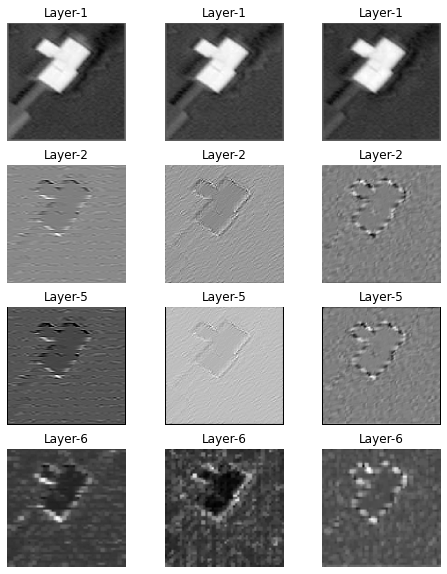

In [ ]:
plot_feature_maps(no_damage)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


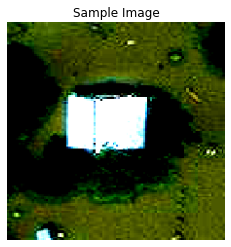

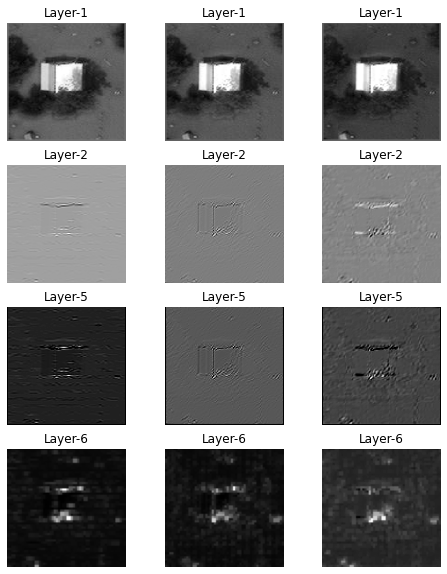

In [ ]:
plot_feature_maps(damage)

**Saliency Map & GradCam Heatmap**

In [ ]:
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

loss_1 = lambda output: tf.keras.backend.mean(output[:, 0])
loss_2 = lambda output: tf.keras.backend.mean(output[:, -1])

In [ ]:
saliency = Saliency(model, model_modifier)

input_image_1 = prepare_image(no_damage,224,224)
input_image_2 = prepare_image(damage,224,224)

saliency_map_1 = saliency(loss_1, input_image_1[0,...], smooth_samples=20)
saliency_map_1 = normalize(saliency_map_1)

saliency_map_2 = saliency(loss_2, input_image_2[0,...], smooth_samples=20)    
saliency_map_2 = normalize(saliency_map_2)

In [ ]:
gradcam_obj = Gradcam(model, model_modifier = model_modifier,clone = False)
cam_1 = gradcam_obj(loss_1, input_image_1[0,...],
                 penultimate_layer = -1)
heat_1 = np.uint8(cm.jet(cam_1)[..., :3] * 255)

cam_2 = gradcam_obj(loss_2, input_image_2[0,...],
              penultimate_layer = -1)
heat_2 = np.uint8(cm.jet(cam_2)[..., :3] * 255)

grad_img_1 = tf.squeeze(heat_1)
grad_img_2 = tf.squeeze(heat_2)

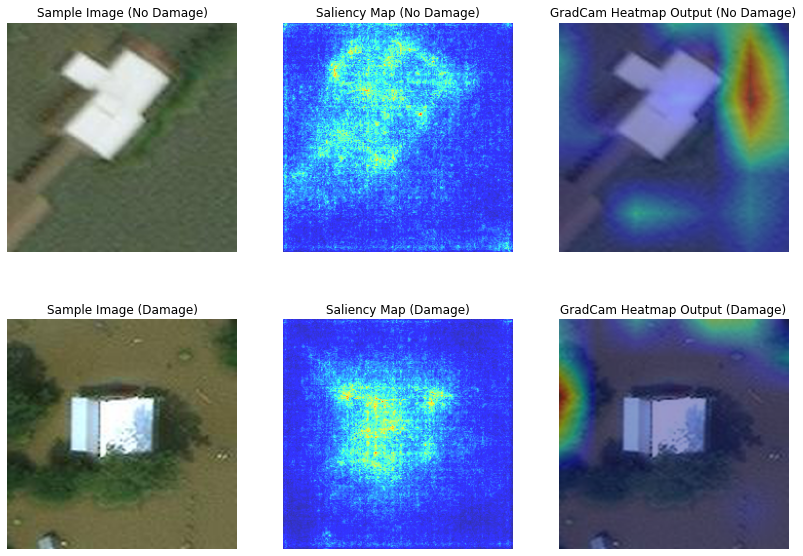

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14, 10))
axes = ax.ravel()
axes[0].set_title('Sample Image (No Damage)')
axes[0].imshow(Image.open(img_path + no_damage).resize((200, 200), Image.ANTIALIAS))
axes[1].set_title('Saliency Map (No Damage)')
axes[1].imshow(saliency_map_1[0],cmap="jet",alpha=0.8)
axes[2].set_title('GradCam Heatmap Output (No Damage)')
axes[2].imshow(Image.open(img_path + no_damage).resize((224, 224), Image.ANTIALIAS))
axes[2].imshow(grad_img_1, cmap = 'jet', alpha = 0.4)
axes[3].set_title('Sample Image (Damage)')
axes[3].imshow(Image.open(img_path + damage).resize((200, 200), Image.ANTIALIAS))
axes[4].set_title('Saliency Map (Damage)')
axes[4].imshow(saliency_map_2[0],cmap="jet",alpha=0.8)
axes[5].set_title('GradCam Heatmap Output (Damage)')
axes[5].imshow(Image.open(img_path + damage).resize((224, 224), Image.ANTIALIAS))
axes[5].imshow(grad_img_2, cmap = 'jet', alpha = 0.4)
for axe in axes:
  axe.grid(False)
  axe.axis('off')

# **Classification using our CNN Architecture**

Finally, after training and evaluation, we can now see how our model performs on the realtime sample data of satelite images that contains data of both the classes. We are taking 10 sample images to evaluate wheather our model is able to classify them correctly. 
Since, we have used used sigmoid activation at output layers, we will get the probabilities as a prediction. If probability is less than 0.5, it means that input image belongs to 'damaged' class and if it is greater than 0.5, it means that it belongs to 'no damaged' class.

In [ ]:
samples_dir = '/content/drive/MyDrive/Project/project_data/sample_images'
samples_preds = {}
for filename in os.listdir(samples_dir):
  img = image.load_img(samples_dir + '/' + filename, target_size=(224, 224))
  img_arr = image.img_to_array(img)
  img_arr_exp = np.expand_dims(img_arr, axis=0)
  pro_img = preprocess_input(img_arr_exp)
  predictions = float(model.predict(pro_img))
  samples_preds[filename] = predictions


In [ ]:
for i,j in zip(samples_preds.keys(),samples_preds.values()):
  if j>0.5:
    samples_preds[i] = 'No Damage'
  else:
    samples_preds[i] = 'Damaged'

In [ ]:
samples_preds

{'sample_1.jpeg': 'Damaged',
 'sample_10.jpeg': 'Damaged',
 'sample_2.jpeg': 'Damaged',
 'sample_3.jpeg': 'No Damage',
 'sample_4.jpeg': 'Damaged',
 'sample_5.jpeg': 'No Damage',
 'sample_6.jpeg': 'Damaged',
 'sample_7.jpeg': 'No Damage',
 'sample_8.jpeg': 'Damaged',
 'sample_9.jpeg': 'No Damage'}

### **Visualizing Predictions**

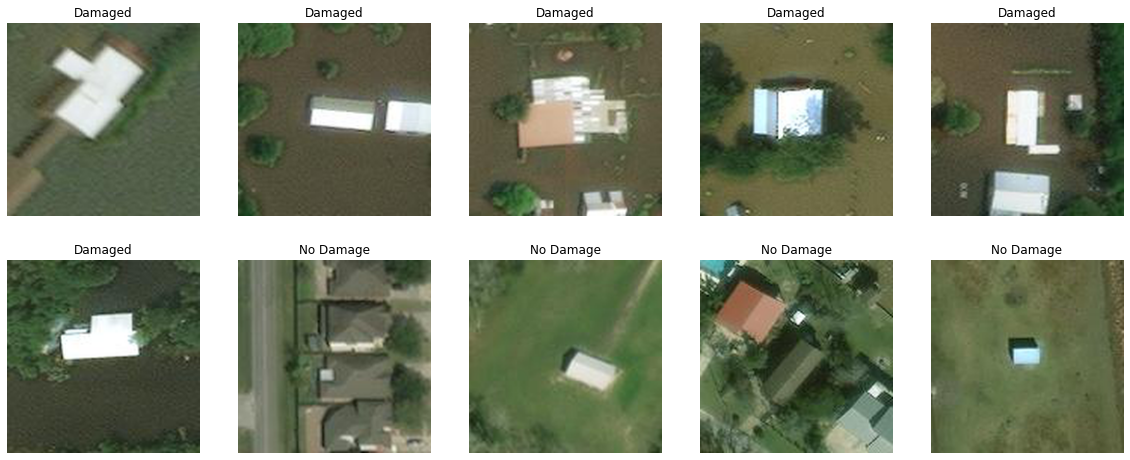

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (20,8))
axes = ax.ravel()
for i,filename in enumerate(os.listdir(samples_dir)):
  axes[i].imshow(Image.open(samples_dir+'/'+ filename).resize((200, 200), Image.ANTIALIAS))
  axes[i].set_title(samples_preds[filename])
for axe in axes:
  axe.grid(False)
  axe.axis('off')

## Voila! 
Our model is able to classify 9/10 images with absolute precision. The labels on the top of every image you see is the predicted class of that picture.

# **Reconstruction Using Convolutional AutoEncoders**

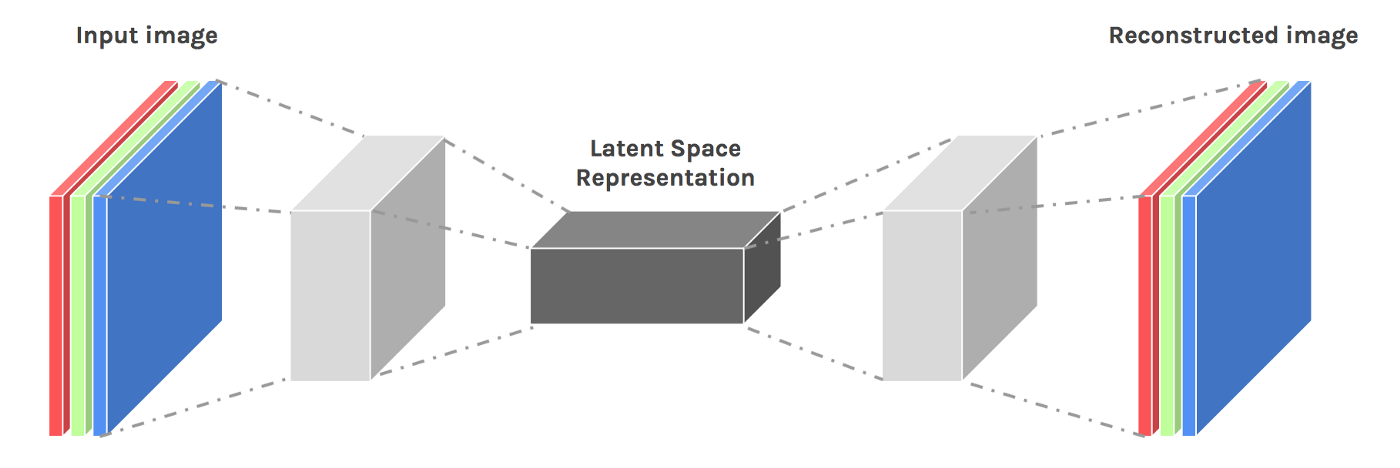

We will now use AutoEncoder to rebult the images that are being classified as 'damaged' by our model in the previous section.

In [ ]:
# We'll try to reconstruct the images that are predicted 'Damaged' from our Model
# using Convolutional AutoEncoder

damaged_sam_imgs = []

for val in samples_preds.keys():
  if samples_preds[val] == 'Damaged':
    damaged_sam_imgs.append(val)

In [ ]:
# List of Sample Images that are Predicted 'Damaged' by our Model
damaged_sam_imgs

['sample_1.jpeg',
 'sample_2.jpeg',
 'sample_10.jpeg',
 'sample_4.jpeg',
 'sample_8.jpeg',
 'sample_6.jpeg']

In [ ]:
# Converting RGB images to CIE L*a*b values
def rgb_converter(image):
  lab_X = rgb2lab(1.0/255*image)[:,:,0]
  lab_y = rgb2lab(1.0/255*image)[:,:,1:]
  X = np.expand_dims(lab_X,axis=[0,3])
  y = np.expand_dims(lab_y,axis=0)
  return X, y

In [ ]:
def cnn_autoencoder(X,y, epochs = 50):
  # Initializing Encoder
  encoder=Sequential()

  # First Conv2D Layer
  encoder.add(Conv2D(8,kernel_size=3,
                     strides=2,
                     padding='same',
                     input_shape=[128,128,1]))
  # Second Conv2D Layer
  encoder.add(Conv2D(8,kernel_size=3,
                     strides=1,
                     padding='same'))
  # Third Conv2D Layer
  encoder.add(Conv2D(16,kernel_size=3,
                     strides=1,
                     padding='same'))
  # Fourth Conv2D Layer
  encoder.add(Conv2D(16,kernel_size=3,
                     strides=2,
                     padding='same'))
  # Fifth Conv2D Layer
  encoder.add(Conv2D(32,kernel_size=3,
                     strides=1,
                     padding='same'))
  # Sixth Conv2D Layer
  encoder.add(Conv2D(32,kernel_size=3,
                     strides=2,
                     padding='same'))
  # Inititializing Decoder
  decoder=Sequential()

  # Upsampling Decoder Layer 
  decoder.add(UpSampling2D(size=2,input_shape=[16,16,32]))
  decoder.add(Conv2D(32,kernel_size=3,
                     strides=1,
                     padding='same'))
  # Upsampling Decoder Layer
  decoder.add(UpSampling2D(size=2))
  decoder.add(Conv2D(16,kernel_size=3,
                     strides=1,
                     padding='same'))
  # Upsampling Decoder Layer
  decoder.add(UpSampling2D(size=2))
  decoder.add(Conv2D(2,kernel_size=3,
                     strides=1,
                     padding='same'))
  
  # Combining Encoder & Decoder
  ae=Sequential([encoder,decoder])

  # conpiling AutoEncoder Architecture
  ae.compile(loss='MSE',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

  # Fitting on data
  ae.fit(X, y, batch_size=1, epochs=epochs, verbose = 0)

  # Taking predictions
  y_pred = ae.predict(X)

  # Converting prediction to CIE L*a*b values
  lab_pred = np.append(np.squeeze(X, axis = 0),y_pred[0],axis=2)

  # Converting L*a*b values to RGB Values
  recontructed = lab2rgb(lab_pred)

  return recontructed

In [ ]:
# Fitting the Damaged Predicted images to our CNN AutoEncoder
reconstructed_dict = {}
for filename in damaged_sam_imgs:
  imgage = img_to_array(load_img(samples_dir+'/'+ filename))
  X, y = rgb_converter(imgage)
  reconstructed_image = cnn_autoencoder(X, y, 50)
  reconstructed_dict[filename] = reconstructed_image

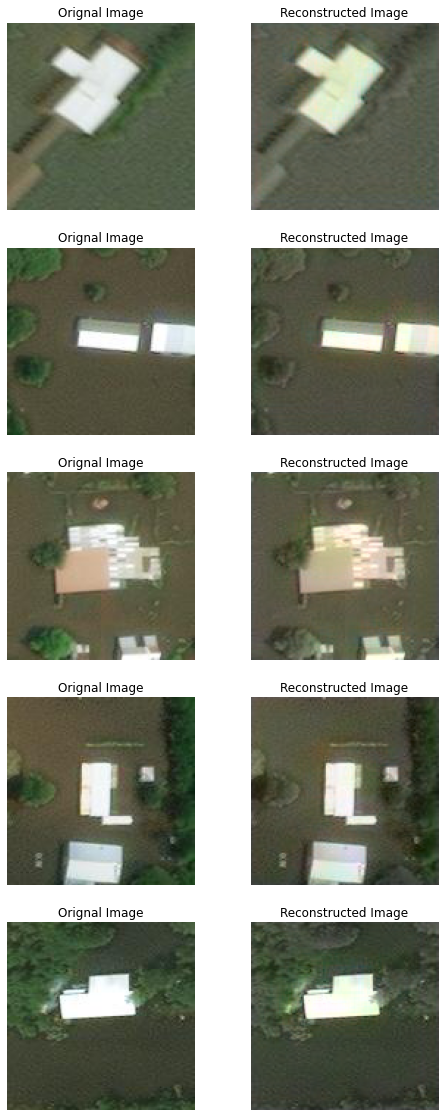

In [ ]:
# Visializing Reconstructed Images along with Orignal Images
fig, ax = plt.subplots(nrows = 5,ncols = 2, figsize = (8,20))
axes = ax.ravel()

axes[0].imshow(img_to_array(load_img(samples_dir + '/' + 'sample_1.jpeg'))/255)
axes[1].imshow(reconstructed_dict['sample_1.jpeg'])
axes[2].imshow(img_to_array(load_img(samples_dir + '/' + 'sample_2.jpeg'))/255)
axes[3].imshow(reconstructed_dict['sample_2.jpeg'])
axes[4].imshow(img_to_array(load_img(samples_dir + '/' + 'sample_10.jpeg'))/255)
axes[5].imshow(reconstructed_dict['sample_10.jpeg'])
axes[6].imshow(img_to_array(load_img(samples_dir + '/' + 'sample_8.jpeg'))/255)
axes[7].imshow(reconstructed_dict['sample_8.jpeg'])
axes[8].imshow(img_to_array(load_img(samples_dir + '/' + 'sample_6.jpeg'))/255)
axes[9].imshow(reconstructed_dict['sample_6.jpeg'])

for i in range(0,9,2):
  axes[i].set_title('Orignal Image')
for j in range(1,10,2):
  axes[j].set_title('Reconstructed Image')
for axe in axes:
  axe.grid(False)
  axe.axis('off')
plt.show()

The images reconstructed have same distinctive feature of the orignal image. 



---


---




---

# ***Thank You !***



---



---

---



